In [1]:
import auction_data, os, analytics
hist_plot = auction_data.hist_plot
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
sns.set_style('white')
%matplotlib inline

## auction analysis packages
- `auction_data` provides tools to access, compute statistics of interest, and manipulate procurement auction data
- `analytics` provides tools to setup and solve a variety of safe tests as described in 

    ''Data-Driven Regulation: Theory and Application to Missing Bids'' (Chassang, Kawai, Nakabayashi and Ortner)

### `auction_data`

First, we'll use `auction_data` to plot the distribution of winning margins, as well as the aggregate demand for auctions in the Tsuchiura dataset.

In [2]:
tsuchiura_data = auction_data.AuctionData('tests/reference_data/tsuchiura_data.csv')

In [3]:
tsuchiura_data.df_auctions.shape

(1469, 2)

In [4]:
tsuchiura_data.df_bids.norm_bid.describe()

count    5876.000000
mean        0.946066
std         0.069519
min         0.099475
25%         0.949772
50%         0.974774
75%         0.984912
max         1.034483
Name: norm_bid, dtype: float64

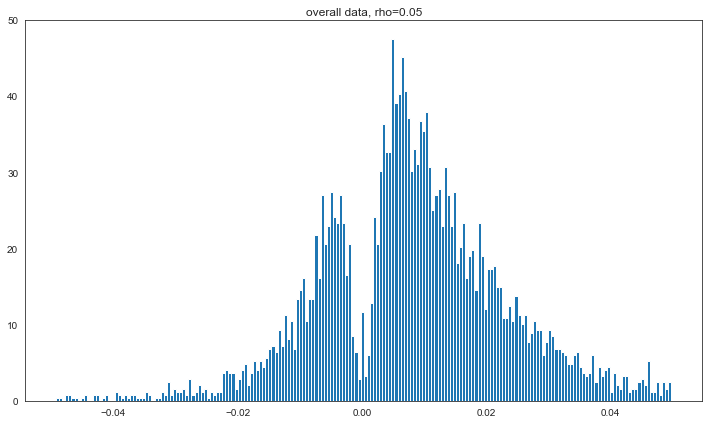

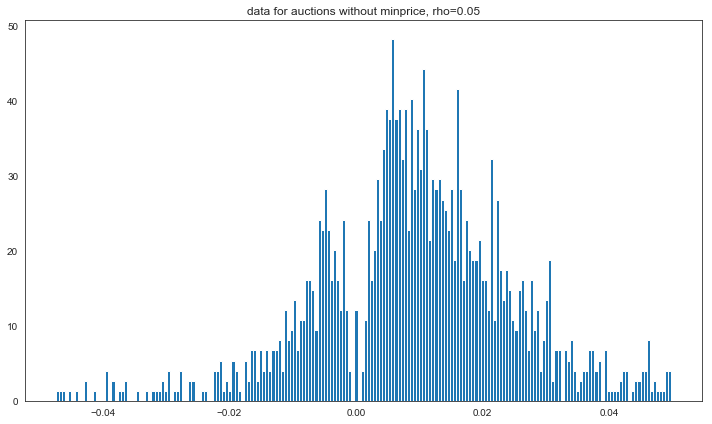

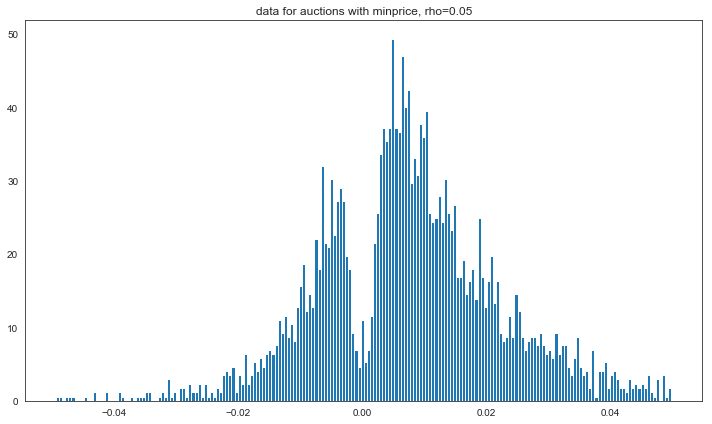

In [5]:
delta = tsuchiura_data.df_bids.norm_bid - tsuchiura_data.df_bids.most_competitive
rho = .05
delta = delta[delta.between(-rho, rho)]
hist_plot(delta,'overall data, rho={}'.format(rho))
hist_plot(delta[tsuchiura_data.data.minprice.isnull()], 
          'data for auctions without minprice, rho={}'.format(rho))
hist_plot(delta[~tsuchiura_data.data.minprice.isnull()], 
          'data for auctions with minprice, rho={}'.format(rho))

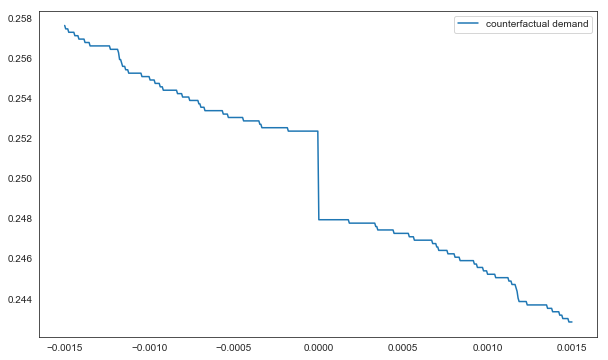

In [6]:
tsuchiura_data.demand_function(-.0015, .0015).plot(figsize = (10,6))

In [7]:
df = tsuchiura_data.demand_function(-rho, rho)

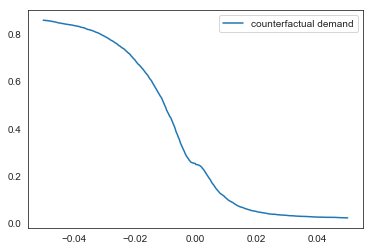

In [8]:
df.plot()

## analytics

Next, we use `analytics` to compute the minimum number of non-competitive histories, as well as the minimum normalized deviation temptation corresponding to deviations $[-.02, -.0001, 0, .0005]$

In [9]:
deviations = [-.02, -.0001, .0, .0005]
demands = [tsuchiura_data.get_counterfactual_demand(rho) for rho in deviations]
print(demands)

[0.6938393464942137, 0.25238257317903334, 0.25017018379850237, 0.24727705922396187]


In [10]:
#constraints = [analytics.MarkupConstraint(max_markup=.5)
constraints = [analytics.InformationConstraint(k=.5, sample_demands=demands)]

In [13]:
# note: here without projection, many environments are eliminated before optimization

min_collusion_solver = analytics.MinCollusionSolver(
    data=tsuchiura_data,
    deviations=deviations,
    tolerance=2 * 1./tsuchiura_data.df_bids.shape[0],
    metric=analytics.IsNonCompetitive,
    plausibility_constraints=constraints,
    num_points=1e6,
    seed=0
)

In [17]:
df = min_collusion_solver._env_with_perf

In [18]:
env = min_collusion_solver.environment
raw_data = env._generate_raw_environments(1e6, seed=6)
data = env._apply_constraints(raw_data)

In [19]:
import seaborn as sns

(1000000, 4)


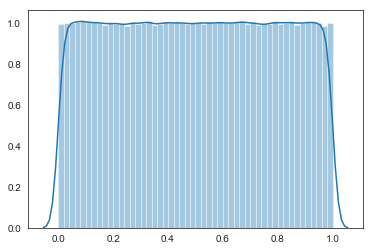

In [20]:
raw_data_shape = raw_data[:,:-1].shape
print(raw_data_shape)
sns.distplot(raw_data[:,-1])


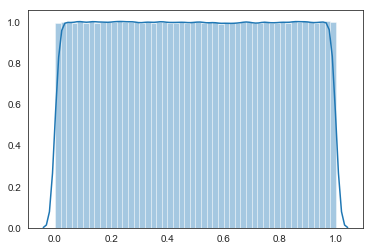

In [21]:
sns.distplot(np.reshape(raw_data[:,:-1], raw_data_shape[0]*raw_data_shape[1]))

(6052, 4)


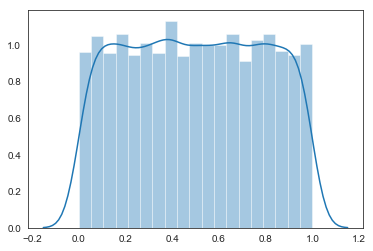

In [22]:
data_shape = data[:,:-1].shape
print(data_shape)
sns.distplot(data[:,-1])

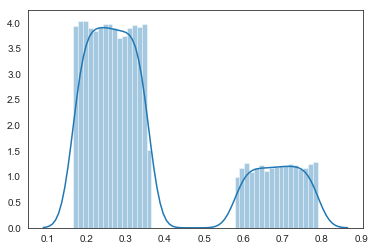

In [23]:
sns.distplot(np.reshape(data[:,:-1], data_shape[0]*data_shape[1]))

In [ ]:
print('minimum share of collusive histories: {}'.format(min_collusion_solver.solution))
print('collusion-minimizing distribution: \n{}'.format(min_collusion_solver.argmin.head()))
min_collusion_solver.argmin.sort_values("prob", ascending=False).head(10)

In [ ]:
from scipy.spatial import ConvexHull

In [ ]:
ch = ConvexHull(df)

In [ ]:
df[ch.vertices].shape

In [ ]:
min_collusion_solver.epigraph_extreme_points

In [25]:
# note: here with projection, no environments are eliminated before optimization
# as a result we get a better solution even though we are sampling less points

min_collusion_solver = analytics.MinCollusionSolver(
    data=tsuchiura_data,
    deviations=deviations,
    tolerance=2 * 1./tsuchiura_data.df_bids.shape[0],
    metric=analytics.IsNonCompetitive,
    plausibility_constraints=constraints,
    num_points=1e4,
    seed=5,
    project=True
)

print('minimum share of collusive histories: {}'.format(min_collusion_solver.solution))
print('collusion-minimizing distribution: \n{}'.format(min_collusion_solver.argmin.head()))
min_collusion_solver.argmin.sort_values("prob", ascending=False).head(10)

minimum share of collusive histories: 0.6052980303236948
collusion-minimizing distribution: 
      -0.02   -0.0001       0.0    0.0005      cost  metric          prob
0  0.781296  0.350104  0.199200  0.192844  0.188415     1.0  2.089053e-11
1  0.713227  0.278331  0.264472  0.166451  0.985624     1.0  4.152407e-11
2  0.772648  0.333267  0.318022  0.214128  0.002214     1.0  4.078184e-11
3  0.770965  0.322791  0.319475  0.275290  0.059822     1.0  8.703051e-11
4  0.645586  0.226592  0.193765  0.191029  0.679183     1.0  1.918907e-10


,-0.02,-0.0001,0.0,0.0005,cost,metric,prob
478,0.740248,0.279671,0.276059,0.223036,0.994765,0.0,3.947020e-01
128,0.719514,0.291438,0.284748,0.279929,0.173516,1.0,3.402245e-01
494,0.604349,0.188413,0.184989,0.181021,0.838598,1.0,2.650734e-01
249,0.769196,0.328764,0.324228,0.317375,0.676411,1.0,3.534409e-09
521,0.654647,0.223488,0.219503,0.216108,0.324392,1.0,3.402057e-09
512,0.754375,0.326228,0.313915,0.309958,0.086913,1.0,3.023927e-09
109,0.732959,0.299050,0.289745,0.285935,0.767718,1.0,2.249378e-09
285,0.702672,0.278932,0.274792,0.266255,0.376036,1.0,2.173794e-09
90,0.663915,0.243294,0.238704,0.231781,0.379825,1.0,2.168679e-09
160,0.608834,0.187659,0.184434,0.179343,0.703398,1.0,1.738117e-09


(10000, 4)


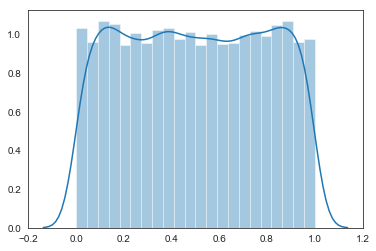

In [27]:
env = min_collusion_solver.environment
raw_data = env._generate_raw_environments(1e4, seed=5)
data = env._apply_constraints(raw_data)
raw_data_shape = raw_data[:,:-1].shape
print(raw_data_shape)
sns.distplot(raw_data[:,-1])

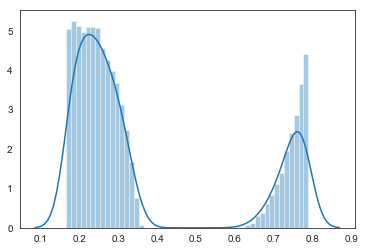

In [28]:
sns.distplot(np.reshape(raw_data[:,:-1], raw_data_shape[0]*raw_data_shape[1]))

In [ ]:
env = min_collusion_solver.environment
raw_data = np.array(env._generate_raw_environments(1e4, seed=5).copy())

In [ ]:
sns.distplot(raw_data[:, -1])

In [ ]:
data = env._apply_constraints(raw_data)
sns.distplot(data[:, -1])

In [ ]:
sns.distplot(raw_data[:, -3])

In [ ]:
sns.distplot(data[:, -2])

## expected properties

In [ ]:
# minimum collusion goes down as k gets bigger
constraints = [analytics.MarkupConstraint(max_markup=2),
               analytics.InformationConstraint(k=.5, sample_demands=demands)]

min_collusion_solver = analytics.MinCollusionSolver(
    data=tsuchiura_data,
    deviations=deviations,
    tolerance=2 * 1./tsuchiura_data.df_bids.shape[0],
    metric=analytics.IsNonCompetitive,
    plausibility_constraints=constraints,
    num_points=1e6,
    seed=5
)

print('minimum share of collusive histories: {}'.format(min_collusion_solver.solution))

In [ ]:
# minimum collusion goes down as the maximum markup gets bigger

constraints = [analytics.MarkupConstraint(max_markup=.5),
               analytics.InformationConstraint(k=.75, sample_demands=demands)]

min_collusion_solver = analytics.MinCollusionSolver(
    data=tsuchiura_data,
    deviations=deviations,
    tolerance=2 * 1./tsuchiura_data.df_bids.shape[0],
    metric=analytics.IsNonCompetitive,
    plausibility_constraints=constraints,
    num_points=1e6,
    seed=5
)

print('minimum share of collusive histories: {}'.format(min_collusion_solver.solution))

In [ ]:
# minimum collusion goes up when the gap in the distribution of bid differences gets bigger

df_bids = tsuchiura_data.df_bids
df_bids = df_bids.loc[tsuchiura_data.raw_data.minprice.isnull()]
delta = delta[delta.between(-rho, rho)]

tsuchiura_no_minprice_data = auction_data.AuctionData(df_bids)

In [ ]:
constraints = [analytics.MarkupConstraint(max_markup=.5),
               analytics.InformationConstraint(k=.5, sample_demands=demands)]

min_collusion_solver = analytics.MinCollusionSolver(
    data=tsuchiura_no_minprice_data,
    deviations=deviations,
    tolerance=2 * 1./tsuchiura_data.df_bids.shape[0],
    metric=analytics.IsNonCompetitive,
    plausibility_constraints=constraints,
    num_points=1e6,
    seed=5
)

print('minimum share of collusive histories: {}'.format(min_collusion_solver.solution))

## some issues

The main issue is that the quality of the solution still changes significantly as we vary 
the seed or the sampling strategy

In [ ]:
constraints = [analytics.MarkupConstraint(max_markup=.5),
               analytics.InformationConstraint(k=.5, sample_demands=demands)]

for seed in [1, 5]:
    for project in [False, True]:
        num_points = 1e6 * (1 - project) + 1e4 * project
        print(20*'=' + '\n'
              + 'seed={}, project={}, num_points={}'.format(seed, project, num_points))
        
        min_collusion_solver = analytics.MinCollusionSolver(
            data=tsuchiura_data,
            deviations=deviations,
            tolerance=2 * 1./tsuchiura_data.df_bids.shape[0],
            metric=analytics.IsNonCompetitive,
            plausibility_constraints=constraints,
            num_points=num_points,
            seed=seed,
            project=project
        )
        
        print('minimum share of collusive histories: {}'.format(min_collusion_solver.solution))

## potential solution to the convergence problem

One potential solution, along the lines of simulated annealing would be to iterate on imperfect solutions,
seeding the sample space with solutions obtained at previous stages. 

This would hopefully let us focus on the important parts of the solution space

In [ ]:
# indeed, in a typical solution, the solution puts meaningful mass only on a few points

highest_weight_points = min_collusion_solver.argmin.sort_values('prob', ascending=False).iloc[:10]
print(highest_weight_points)
highest_weight_points.prob.sum()